# Neural Network

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sympy import Matrix
from IPython.display import display, Math
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)

In [2]:
def plot_decision_boundary(pred_func,X,y):
    x_min, x_max = 0, 1.5
    y_min, y_max = 0, 1.5
    h = 0.01
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8,8))
    plt.rc('font', size=12)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

In [3]:
def prec_mat(y,yhat):
    
    y_true = len(y[y==1])
    y_false = len(y[y==0])
    
    yhat_true = len(yhat[yhat==1])
    yhat_false = len(yhat[yhat==0])
    
    error = y - yhat
    
    inc_true = len(error[error==1])
    inc_false = len(error[error==-1])
    
    cor_true = y_true - inc_true
    cor_false = y_false - inc_false
    
    y_mat = np.array([[cor_true/y_true,inc_false/y_false],[inc_true/y_true,cor_false/y_false]])
  
    return y_mat

## Load Data 

It was noticed in training the least sqaured algorithim that there were two features that created a clear boundary layer. The other algorithims were not capable of creating the boundary line with just two features. As a result, additional features that didn't have as clear boundaries were used to have a higher dimensional feature space. However, a neural network is capable of making a more complicated decision boundary.

A neural netwrok should be less sensistive to the imbalance in the data but it will still be affected by and be subject to overfitting. To see the impact of this, a neural network will be trained with and without oversampling. The parameters for both neural networks will be set to the same.

### Training

In [4]:
data = pd.read_csv('nasa_train.csv')
data.drop(['Est Dia in KM(max)','Relative Velocity km per sec','Miss Dist.(kilometers)','Orbit Uncertainity','Jupiter Tisserand Invariant',
           'Epoch Osculation','Eccentricity','Semi Major Axis','Inclination','Asc Node Longitude','Orbital Period',
           'Perihelion Distance','Perihelion Arg','Aphelion Dist','Perihelion Time','Mean Anomaly','Mean Motion']
           ,axis=1,inplace=True)

y_pre = data.Hazardous.values.reshape(-1,1)
y_pre = 1/2 * (y_pre + 1)
y_pre = y_pre.astype(int)
y_pre = y_pre.flatten()

X_pre = data.drop(['Hazardous'],axis=1).values
X_scale = np.max(X_pre,axis=0)
X_pre = np.divide(X_pre,X_scale)

### Testing

In [5]:
data = pd.read_csv('nasa_test.csv')
data.drop(['Est Dia in KM(max)','Relative Velocity km per sec','Miss Dist.(kilometers)','Orbit Uncertainity','Jupiter Tisserand Invariant',
           'Epoch Osculation','Eccentricity','Semi Major Axis','Inclination','Asc Node Longitude','Orbital Period',
           'Perihelion Distance','Perihelion Arg','Aphelion Dist','Perihelion Time','Mean Anomaly','Mean Motion']
           ,axis=1,inplace=True)
y_test = data.Hazardous.values.reshape(-1,1)
y_test = 1/2 * (y_test + 1)
y_test = y_test.astype(int)
X_test = data.drop(['Hazardous'],axis=1).values
X_test = np.divide(X_test,X_scale)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)

## Training

### Training without SMOTE

In [6]:
X = X_pre
X_scale = np.max(X,axis=0)
X = np.divide(X,X_scale)
y = y_pre

X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.LongTensor)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,2)
        
    def forward(self,x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x
              
    def predict(self,x):
        pred = F.softmax(self.forward(x))
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [8]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100000
losses = []
for i in range(epochs):
    y_pred = model.forward(X)
    loss = criterion(y_pred,y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.predict(x)
    return ans.numpy()

<ipython-input-7-27f7049da41d>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


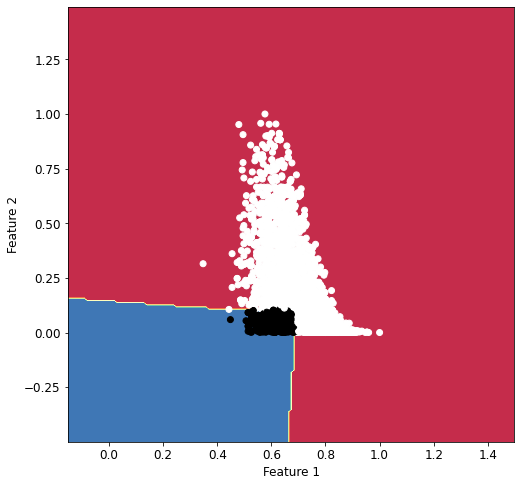

In [9]:
plot_decision_boundary(lambda x : predict(x),X.numpy(),y.numpy())

In [10]:
yhat = model.predict(X)
yhat = yhat.numpy()
yhat = np.reshape(yhat,y.shape)

err = y - yhat
error = np.count_nonzero(err) / len(y)
print('The error is',np.round(error*100,1),'%')

conf_mat = prec_mat(y,yhat)
display(Matrix(np.round(conf_mat*100,1)))

The error is 0.4 %


<ipython-input-7-27f7049da41d>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


Matrix([
[98.2,  0.1],
[ 1.8, 99.9]])

### Testing without SMOTE

In [11]:
yhat_test = model.predict(X_test)
yhat_test = yhat_test.numpy()
yhat_test = np.reshape(yhat_test,y_test.shape)

err = y_test - yhat_test
error = np.count_nonzero(err) / len(y_test)
print('The test error is',np.round(error*100,1),'%')

conf_mat = prec_mat(y_test,yhat_test)
display(Matrix(np.round(conf_mat*100,1)))

The test error is 0.0 %


<ipython-input-7-27f7049da41d>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


Matrix([
[100.0,   0.0],
[  0.0, 100.0]])

### Training with SMOTE

In [12]:
X, y = sm.fit_sample(X_pre, y_pre.ravel()) 

X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.LongTensor)

In [13]:
class Net_SMOTE(nn.Module):
    def __init__(self):
        super(Net_SMOTE,self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,2)
        
    def forward(self,x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x
              
    def predict(self,x):
        pred = F.softmax(self.forward(x))
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [14]:
model_SMOTE = Net_SMOTE()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_SMOTE.parameters(), lr=0.01)

epochs = 100000
losses = []
for i in range(epochs):
    y_pred = model_SMOTE.forward(X)
    loss = criterion(y_pred,y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model_SMOTE.predict(x)
    return ans.numpy()

<ipython-input-13-92a29a4afe29>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


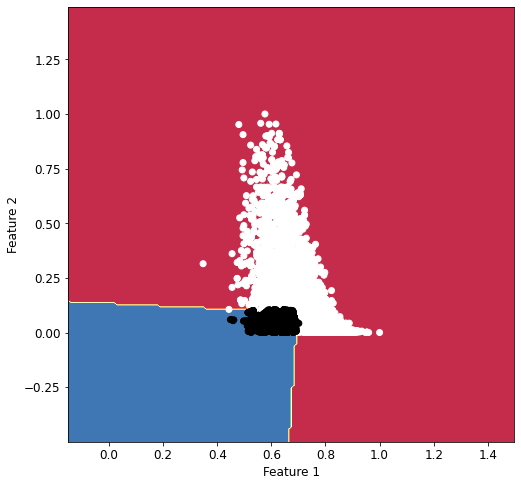

In [15]:
plot_decision_boundary(lambda x : predict(x),X.numpy(),y.numpy())

In [16]:
yhat = model_SMOTE.predict(X)
yhat = yhat.numpy()
yhat = np.reshape(yhat,y.shape)

err = y - yhat
error = np.count_nonzero(err) / len(y)
print('The error is',np.round(error*100,1),'%')

conf_mat = prec_mat(y,yhat)
display(Matrix(np.round(conf_mat*100,1)))

The error is 0.4 %


<ipython-input-13-92a29a4afe29>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


Matrix([
[99.6,  0.5],
[ 0.4, 99.5]])

### Testing with SMOTE

In [17]:
yhat_test = model_SMOTE.predict(X_test)
yhat_test = yhat_test.numpy()
yhat_test = np.reshape(yhat_test,y_test.shape)

err = y_test - yhat_test
error = np.count_nonzero(err) / len(y_test)
print('The test error is',np.round(error*100,1),'%')

conf_mat = prec_mat(y_test,yhat_test)
display(Matrix(np.round(conf_mat*100,1)))

The test error is 0.4 %


<ipython-input-13-92a29a4afe29>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


Matrix([
[100.0,  0.5],
[  0.0, 99.5]])

## Analysis

Both neural networks create similair boundaries and overall error. However, the neural network on the oversampled data led to a better balance in the error between the two classes. For this dataset, the accuracy of the hazardous class is more important so the oversampled neural network will be suggested. 